# Image Classification

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
from sklearn import preprocessing

# Implement Preprocess Functions

def normalize(x):
    return x / float(255)

def normalize(x):
    return x / float(255)

def one_hot_encode(x):
    return encode_labels(x)

def encode_labels(x):
    lb     = preprocessing.LabelBinarizer()
    labels = np.arange(10)
    lb.fit(labels)

    return lb.transform(x)

In [4]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [7]:
import pickle
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [8]:
# Build the network
import tensorflow as tf

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=((None,) + image_shape), name='x')

def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=(None, n_classes), name='y')

def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name='keep_prob')

In [11]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    bias    = tf.Variable(tf.zeros([conv_num_outputs]))
    shape   = [conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[-1], conv_num_outputs]
    weights = tf.Variable(tf.truncated_normal(shape=shape, mean=0.0, stddev=0.1))
    
    conv = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    conv = tf.nn.bias_add(conv, bias)
    conv = tf.nn.relu(conv)
    
    return tf.nn.max_pool(conv, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')

def flatten(x_tensor):
    return tf.contrib.layers.flatten(x_tensor)

def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    bias    = tf.Variable(tf.zeros(num_outputs))
    shape   = [int(x_tensor.get_shape()[1]), num_outputs]
    weights = tf.Variable(tf.truncated_normal(shape=shape, mean=0, stddev=0.1))
    
    return tf.nn.relu(tf.add(tf.matmul(x_tensor, weights), bias))

def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    bias    = tf.Variable(tf.zeros([num_outputs]))
    shape   = [int(x_tensor.get_shape()[1]), num_outputs]
    weights = tf.Variable(tf.truncated_normal(shape=shape, mean=0, stddev=0.1))
    
    return tf.add(tf.matmul(x_tensor, weights), bias)

In [12]:
#Create Convolutional Model

def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    x_tensor          = x
    conv_num_outputs  = 64
    conv_ksize        = [6, 6]
    conv_strides      = [2, 2]
    pool_ksize        = [3, 3]
    pool_strides      = [2, 2]

    conv = conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv = tf.nn.dropout(conv, keep_prob)
    conv = flatten(conv)
    conv = fully_conn(conv, 256) 
    conv = tf.nn.dropout(conv, keep_prob)
    conv = output(conv, 10);

    return conv

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Neural Network Built!


In [13]:
# Train the Neural Network

def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    feed_dict = {
        x: feature_batch,
        y: label_batch,
        keep_prob: keep_probability
    };
    
    session.run(optimizer, feed_dict)

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = sess.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.
    })
    
    validation_accuracy = sess.run(accuracy, feed_dict={
        x: valid_features,
        y: valid_labels,
        keep_prob: 1.
    })
    
    print("Loss: {:>.3f} Validation Accuracy: {:.6f}".format(loss, validation_accuracy))

In [255]:
# Define Hyperparameters

epochs = 60
batch_size = 1024
keep_probability = .75

In [262]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.170 Validation Accuracy: 0.246600
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.895 Validation Accuracy: 0.345600
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.700 Validation Accuracy: 0.418200
Epoch  4, CIFAR-10 Batch 1:  Loss: 1.570 Validation Accuracy: 0.439800
Epoch  5, CIFAR-10 Batch 1:  Loss: 1.439 Validation Accuracy: 0.474000
Epoch  6, CIFAR-10 Batch 1:  Loss: 1.357 Validation Accuracy: 0.494600
Epoch  7, CIFAR-10 Batch 1:  Loss: 1.257 Validation Accuracy: 0.507000
Epoch  8, CIFAR-10 Batch 1:  Loss: 1.181 Validation Accuracy: 0.520000
Epoch  9, CIFAR-10 Batch 1:  Loss: 1.125 Validation Accuracy: 0.532000
Epoch 10, CIFAR-10 Batch 1:  Loss: 1.046 Validation Accuracy: 0.540000
Epoch 11, CIFAR-10 Batch 1:  Loss: 0.996 Validation Accuracy: 0.552000
Epoch 12, CIFAR-10 Batch 1:  Loss: 0.945 Validation Accuracy: 0.557600
Epoch 13, CIFAR-10 Batch 1:  Loss: 0.906 Validation Accuracy: 0.549800
Epoch 14, CIFAR-10 Batch 1:  Loss:

In [263]:
# Train full model
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.096 Validation Accuracy: 0.265800
Epoch  1, CIFAR-10 Batch 2:  Loss: 1.767 Validation Accuracy: 0.385600
Epoch  1, CIFAR-10 Batch 3:  Loss: 1.531 Validation Accuracy: 0.422000
Epoch  1, CIFAR-10 Batch 4:  Loss: 1.446 Validation Accuracy: 0.458000
Epoch  1, CIFAR-10 Batch 5:  Loss: 1.512 Validation Accuracy: 0.478400
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.475 Validation Accuracy: 0.485800
Epoch  2, CIFAR-10 Batch 2:  Loss: 1.377 Validation Accuracy: 0.504800
Epoch  2, CIFAR-10 Batch 3:  Loss: 1.222 Validation Accuracy: 0.508200
Epoch  2, CIFAR-10 Batch 4:  Loss: 1.176 Validation Accuracy: 0.528000
Epoch  2, CIFAR-10 Batch 5:  Loss: 1.277 Validation Accuracy: 0.545400
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.276 Validation Accuracy: 0.549600
Epoch  3, CIFAR-10 Batch 2:  Loss: 1.185 Validation Accuracy: 0.558000
Epoch  3, CIFAR-10 Batch 3:  Loss: 1.083 Validation Accuracy: 0.557600
Epoch  3, CIFAR-10 Batch 4:  Loss: 1.050 Validation Accuracy: 0.5

Testing Accuracy: 0.7096622228622437



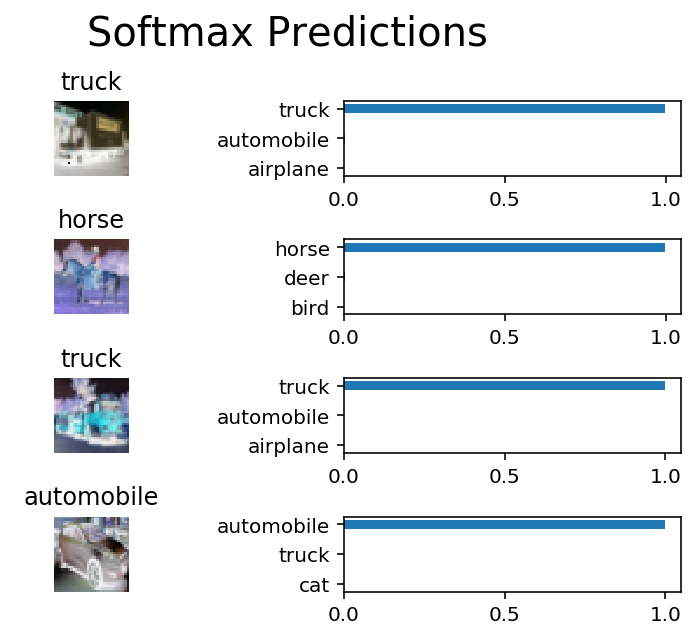

In [266]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()